In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(y_scores,p, r, thresholds, t= 0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    
    # plot the curve
    sns.set()
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.00])
    plt.xlim([0.0, 1.00])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
def transform(data):
    return data.apply(np.sqrt)
    
def inverseTransform(data):
    return np.power(data,2)

In [3]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [4]:
#Set TourID to index
df= df.set_index('TourID_dimension')


# remove outliers:
pU, pL = np.percentile(df['?TourGeneration'], [99.85 ,0.15])
df = df.loc[df['?TourGeneration'] <= (pU)]
df = df.loc[df['?TourGeneration'] >= (pL)]
pU, pL = np.percentile(df['TourContractGeneration'], [99.85 ,0.15])
df = df.loc[df['TourContractGeneration'] <= (pU)]
df = df.loc[df['TourContractGeneration'] >= (pL)]

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}
dic1 = {'Yes':1,'No':0}
dic2 = {'In State':1,'Out of State':0}
dic3 = {'Owner':1,'1st Gen':0}
dic4 = {'Couple':1,'Single':0}
dic5 = {'Weekday':0, 'Weekend':1}
dic6 = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
dic7 = {2016:0, 2017:1, 2018:2}

# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)
df['Homeowner']=df['Homeowner'].replace(dic1)
df['InState']=df['InState'].replace(dic2)
df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)
df['relationStatus']=df['relationStatus'].replace(dic4)
df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)
df['Month of TourDate']=df['Month of TourDate'].replace(dic6)
df['Year of TourDate']=df['Year of TourDate'].replace(dic7)


dfClassification = df.copy()
dfRegression = df[df['ResultOfTour']==1].copy()

In [5]:
# remove outliers from regression predicting model:
dfRegression['NetVolumePlusNonGoodVolume'] = transform(dfRegression['NetVolumePlusNonGoodVolume'])
pU, pL = np.percentile(dfRegression['NetVolumePlusNonGoodVolume'], [99.85 ,0.15])
dfRegression = dfRegression.loc[dfRegression['NetVolumePlusNonGoodVolume'] <= (pU)]
dfRegression = dfRegression.loc[dfRegression['NetVolumePlusNonGoodVolume'] >= (pL)]

In [6]:
dfXRegression = dfRegression.drop(['ResultOfTour', 'NetVolumePlusNonGoodVolume'], axis = 1).copy()


dfXRegression = pd.get_dummies(dfXRegression, prefix=[ 'AgentLine','BookingWindow',
       'HHIncomeRanges', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfXRegression[['Age']])
dfXRegression['Age'] = scaler1.transform(dfXRegression[['Age']])

scaler2 = StandardScaler()
scaler2.fit(dfXRegression[['TourContractGeneration']])
dfXRegression['TourContractGeneration'] = scaler2.transform(dfXRegression[['TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfXRegression[['?TourGeneration']])
dfXRegression['?TourGeneration'] = scaler3.transform(dfXRegression[['?TourGeneration']])

X_trainR, X_testR, y_trainR, y_testR = train_test_split(dfXRegression, dfRegression['NetVolumePlusNonGoodVolume'],  test_size=0.2,random_state = 42)

In [7]:
dfXClassification = dfClassification.drop(['ResultOfTour', 'NetVolumePlusNonGoodVolume'], axis = 1).copy()

dfXClassification = pd.get_dummies(dfXClassification, prefix=[ 'AgentLine','BookingWindow',
       'HHIncomeRanges', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfXClassification[['Age']])
dfXClassification['Age'] = scaler1.transform(dfXClassification[['Age']])

scaler2 = StandardScaler()
scaler2.fit(dfXClassification[['TourContractGeneration']])
dfXClassification['TourContractGeneration'] = scaler2.transform(dfXClassification[['TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfXClassification[['?TourGeneration']])
dfXClassification['?TourGeneration'] = scaler3.transform(dfXClassification[['?TourGeneration']])

X_trainC, X_testC, y_trainC, y_testC = train_test_split(dfXClassification, dfClassification['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)


In [8]:
clf = RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_leaf =100)
clf.fit(X_trainC,y_trainC)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
reg = RandomForestRegressor(n_estimators=1000,min_samples_leaf =10)
reg.fit(X_trainR,y_trainR)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
# chunk with threshold
clfPreds = clf.predict_proba(X_testC)[:,1]
# clfPreds = np.array(adjusted_classes(clfPreds, 0.14726359245514212))
regPreds = reg.predict(X_testC)

In [11]:
clfDF = X_testC.copy()
clfDF['predResult'] = clfPreds
clfDF['predVolume'] = inverseTransform(regPreds)
clfDF['ProspectValue'] =  clfPreds*(inverseTransform(regPreds))
dfRegression['NetVolumePlusNonGoodVolume'] = inverseTransform(dfRegression['NetVolumePlusNonGoodVolume'])

In [12]:
clfDF['Age'] = np.round(scaler1.inverse_transform(clfDF[['Age']]),0)
clfDF['?TourGeneration'] = np.round(scaler3.inverse_transform(clfDF[['?TourGeneration']]),0)
clfDF['TourContractGeneration'] = np.round(scaler2.inverse_transform(clfDF[['TourContractGeneration']]),0)

In [13]:
inv_dic1 = {v: k for k, v in dic1.items()}
inv_dic2 = {v: k for k, v in dic2.items()}
inv_dic3 = {v: k for k, v in dic3.items()}
inv_dic4 = {v: k for k, v in dic4.items()}
inv_dic5 = {v: k for k, v in dic5.items()}
inv_dic6 = {v: k for k, v in dic6.items()}
inv_dic7= {v: k for k, v in dic7.items()}

In [14]:
df['Homeowner']=df['Homeowner'].replace(inv_dic1)
df['InState']=df['InState'].replace(inv_dic2)
df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(inv_dic3)
df['relationStatus']=df['relationStatus'].replace(inv_dic4)
df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(inv_dic5)
df['Month of TourDate']=df['Month of TourDate'].replace(inv_dic6)
df['Year of TourDate']=df['Year of TourDate'].replace(inv_dic7)


clfDF['Homeowner']=clfDF['Homeowner'].replace(inv_dic1)
clfDF['InState']=clfDF['InState'].replace(inv_dic2)
clfDF['FirstGenVsOwner']=clfDF['FirstGenVsOwner'].replace(inv_dic3)
clfDF['relationStatus']=clfDF['relationStatus'].replace(inv_dic4)
clfDF['WeekdayOrWeekend']=clfDF['WeekdayOrWeekend'].replace(inv_dic5)
clfDF['Month of TourDate']=clfDF['Month of TourDate'].replace(inv_dic6)
clfDF['Year of TourDate']=clfDF['Year of TourDate'].replace(inv_dic7)

In [15]:
# create generation bins
age_dic = dict([(n, 'Millenial')for n in range(20, 38)] +
[(n, 'Gen X')for n in range(38, 54)] +
[(n, 'Baby Boomer')for n in range(54, 73)] +
[(n, 'Silent Gen')for n in range(73, 91)])
clfDF['Age'] = clfDF['Age'].replace(age_dic)
df['Age'] = df.Age.replace(age_dic)

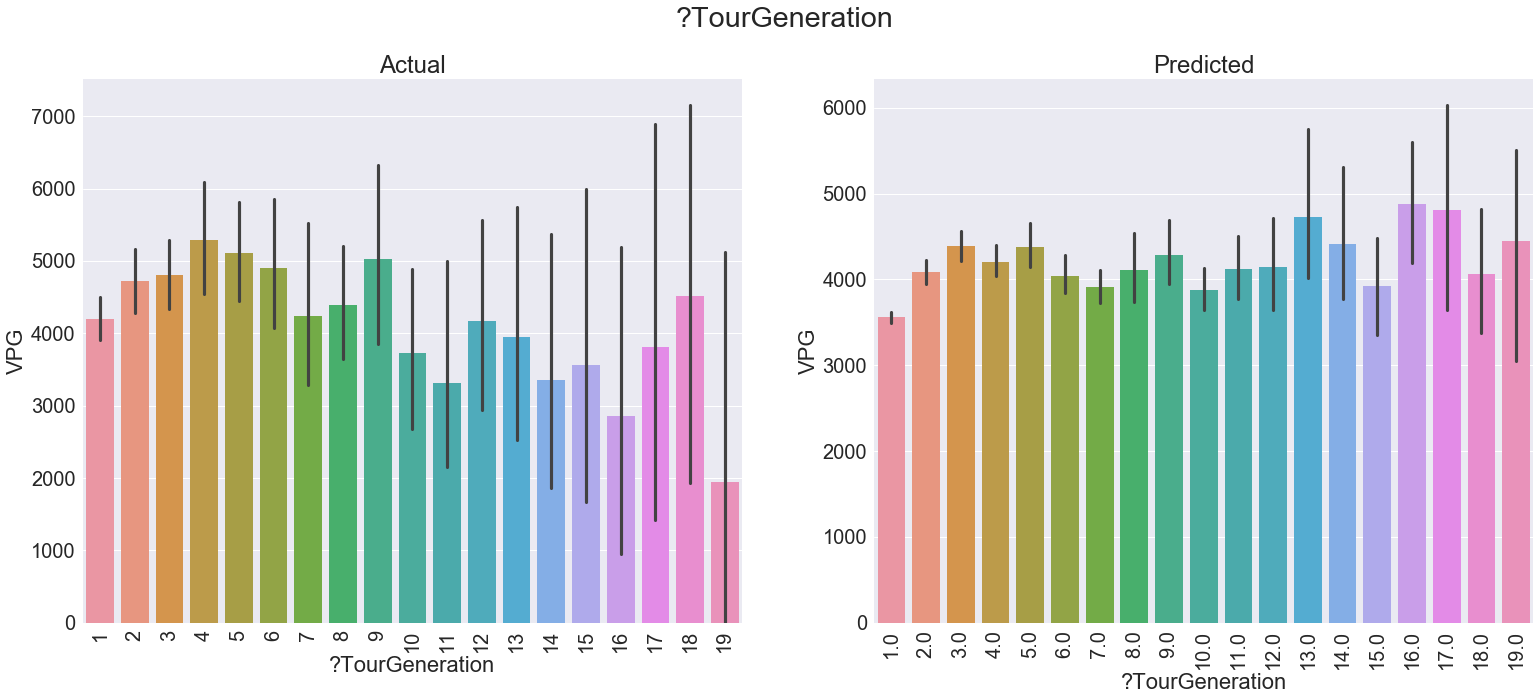

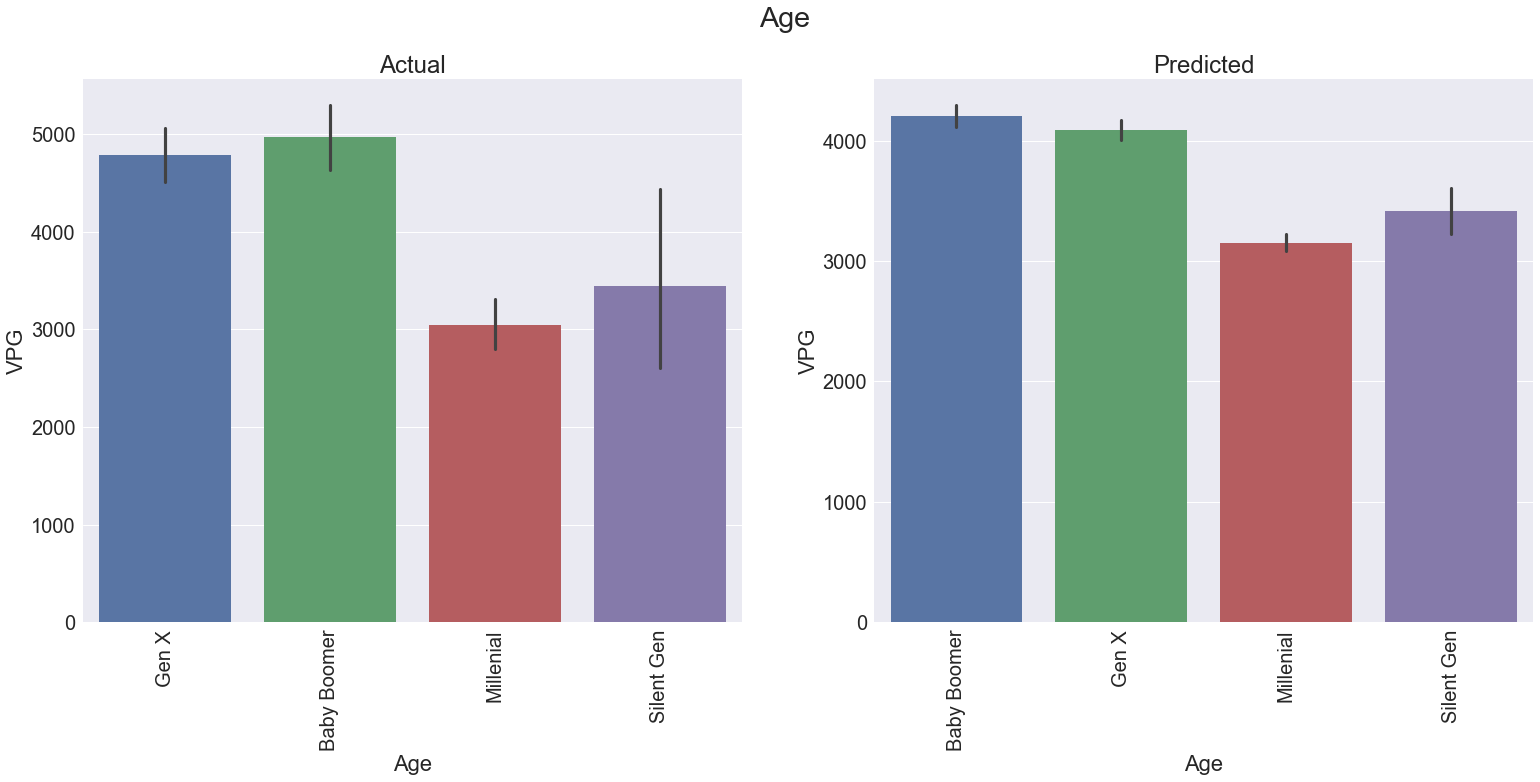

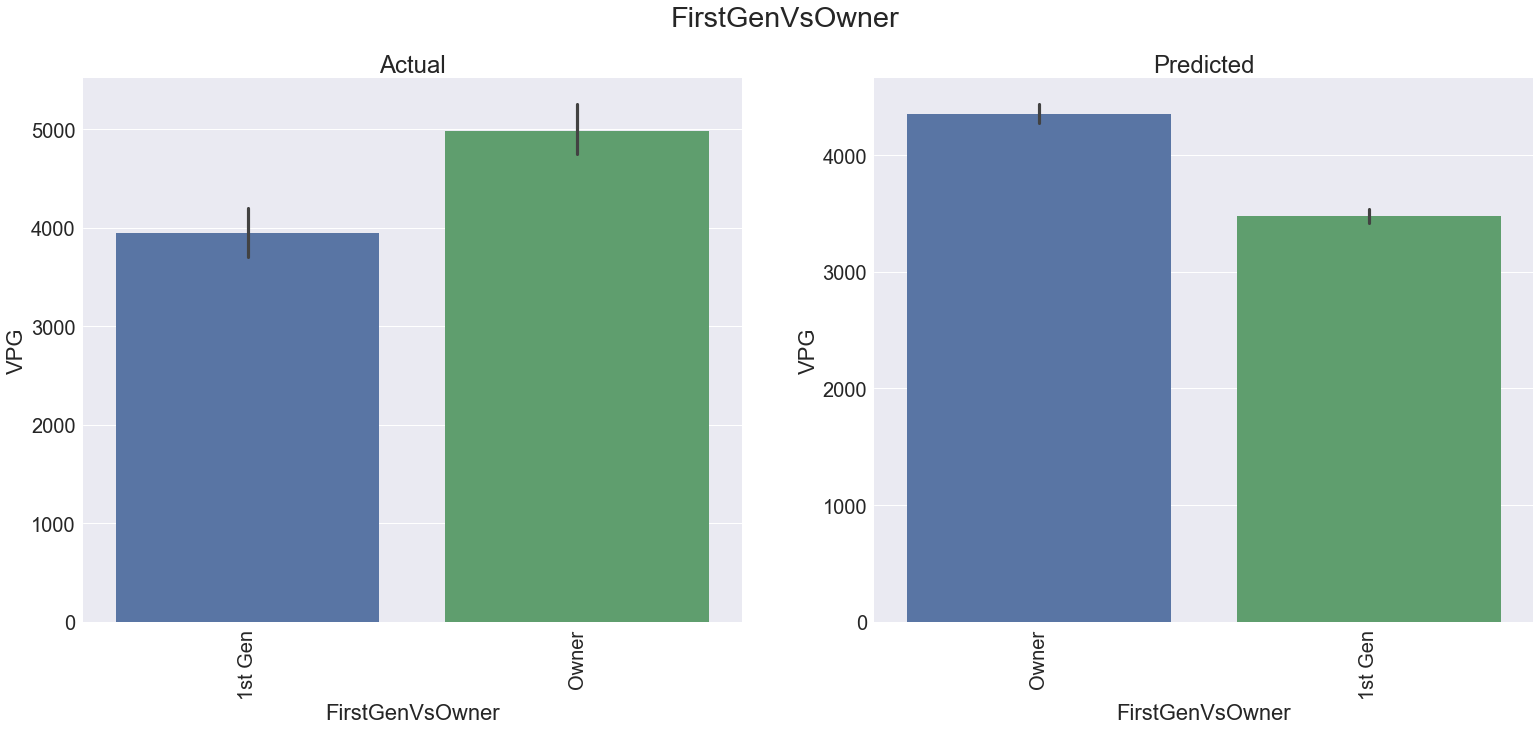

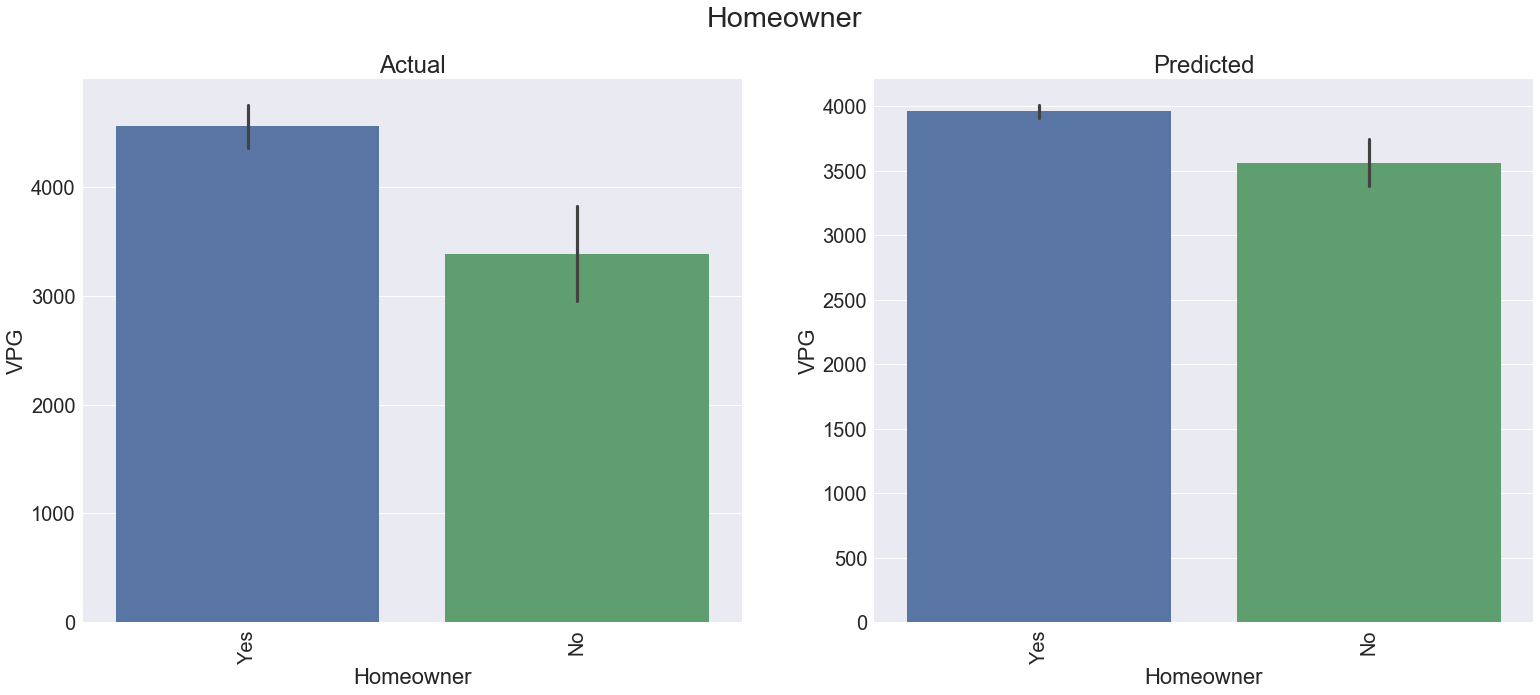

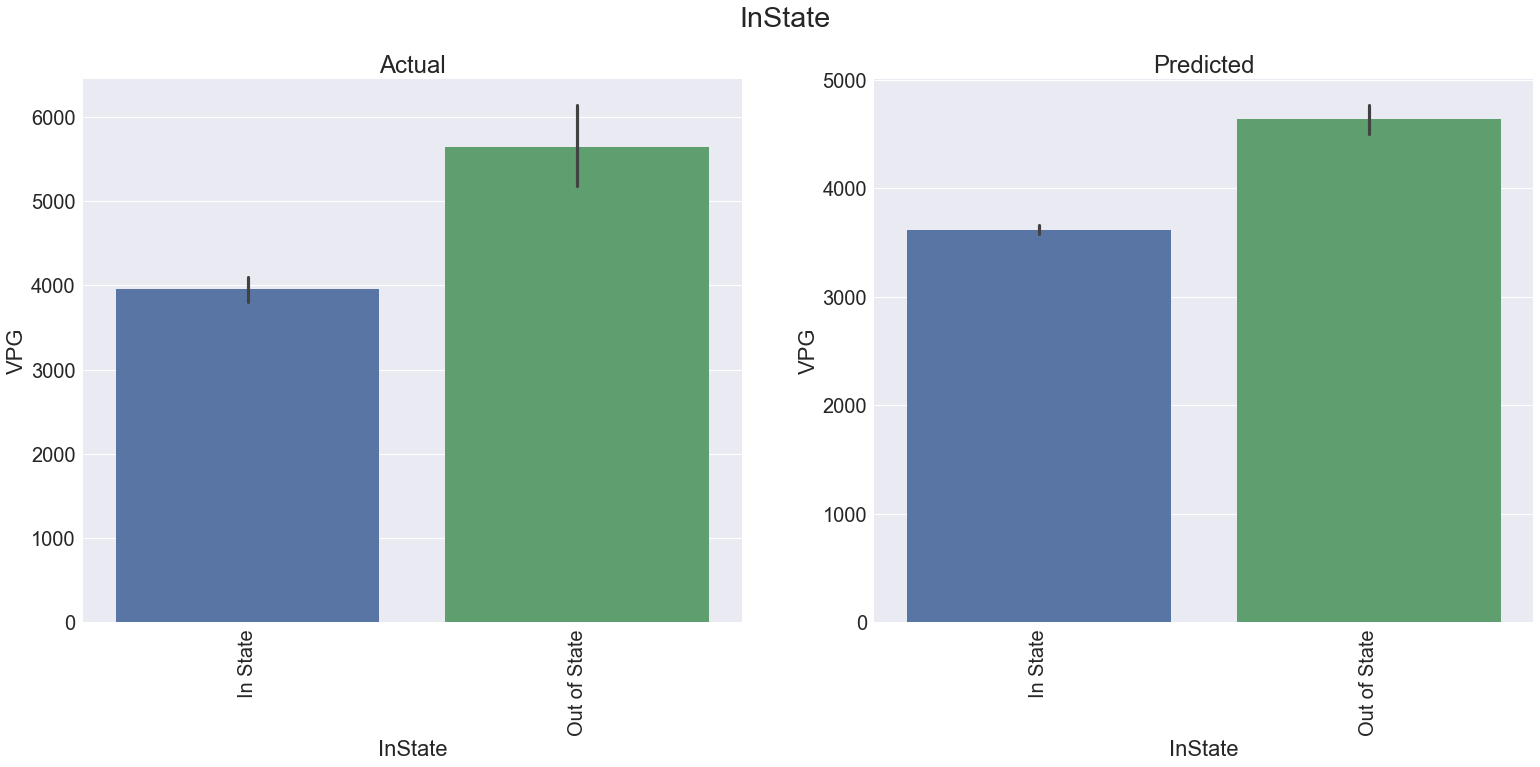

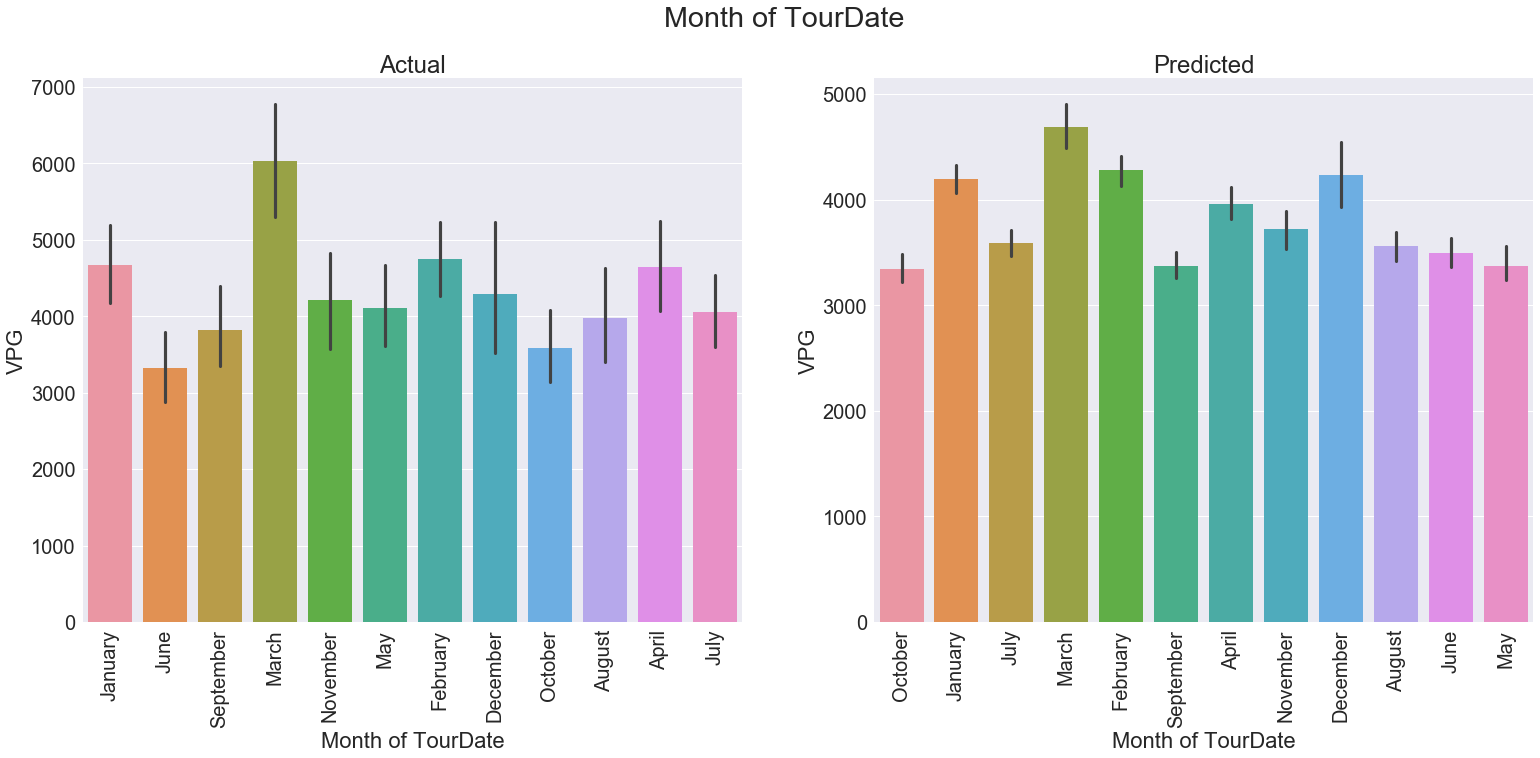

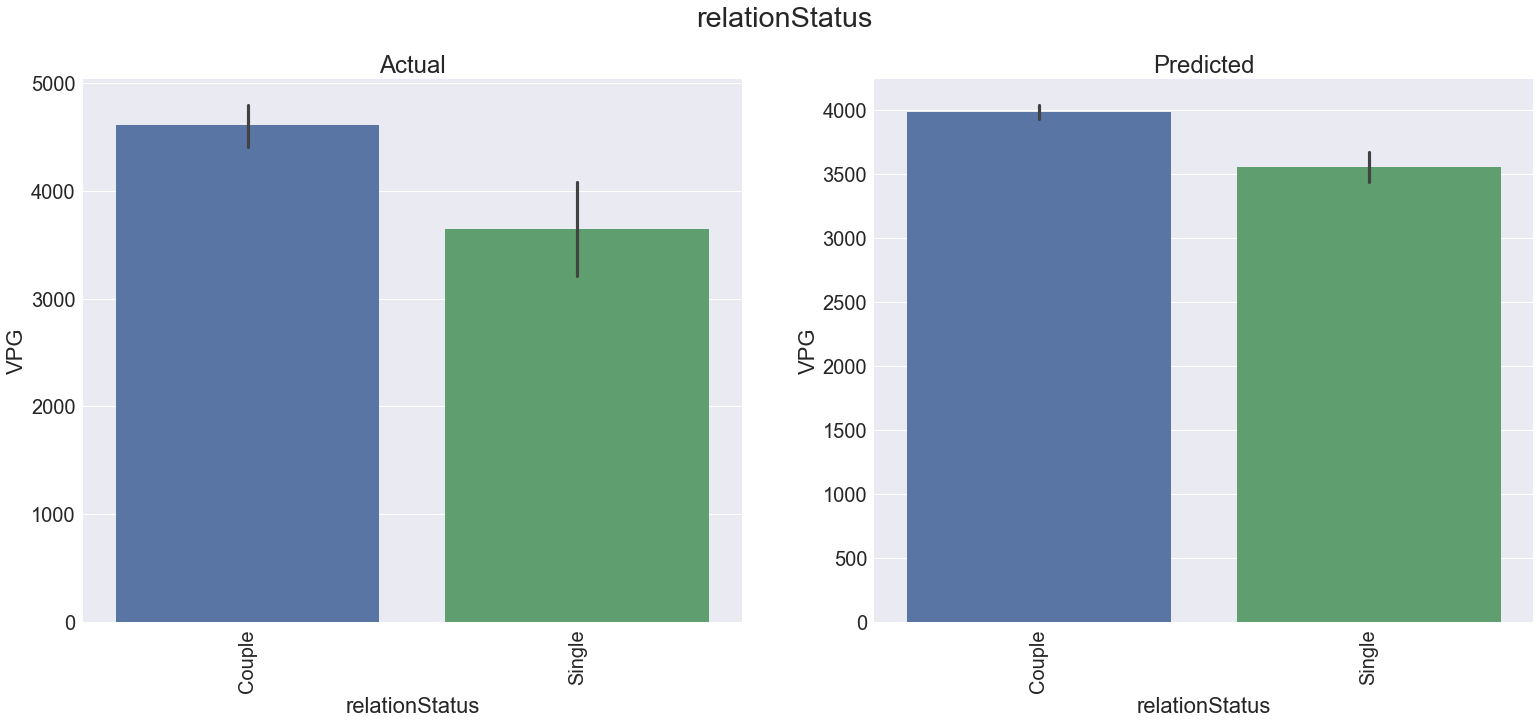

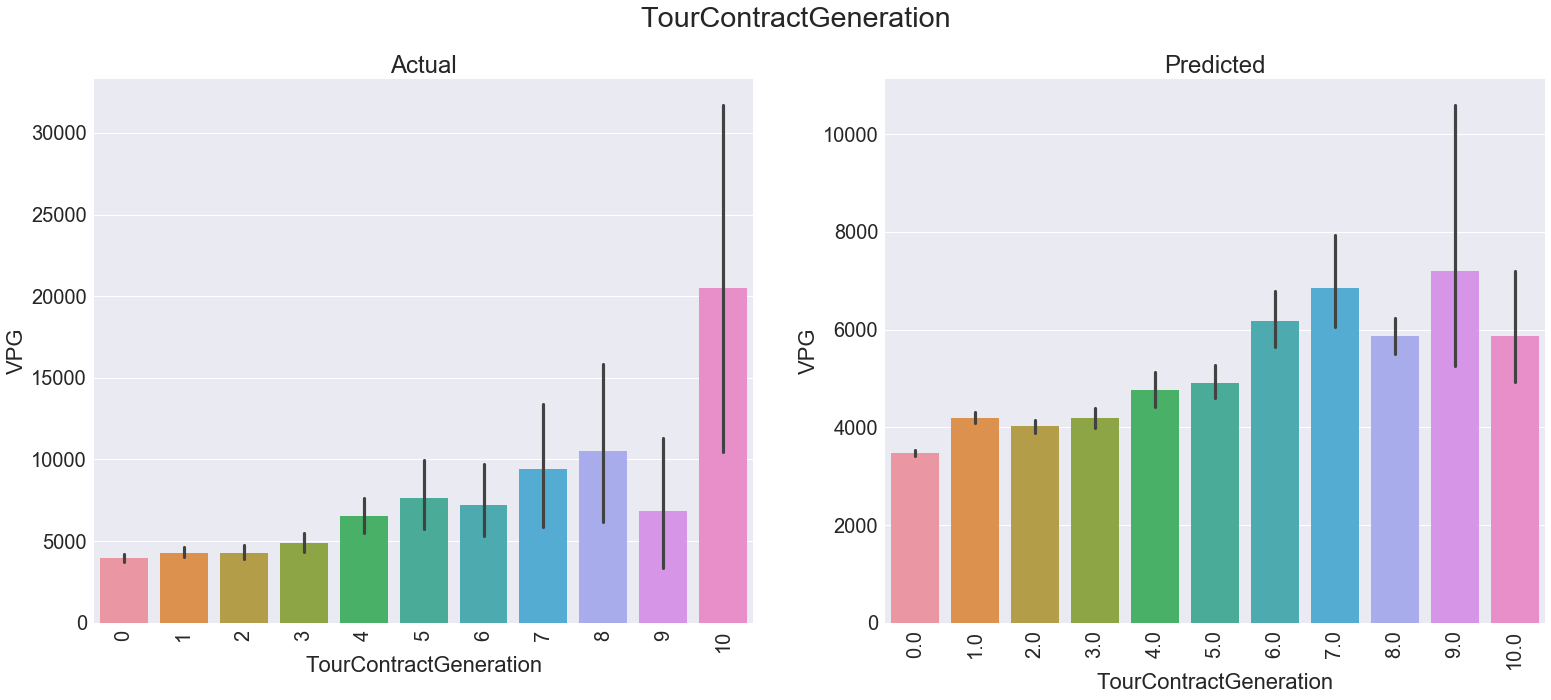

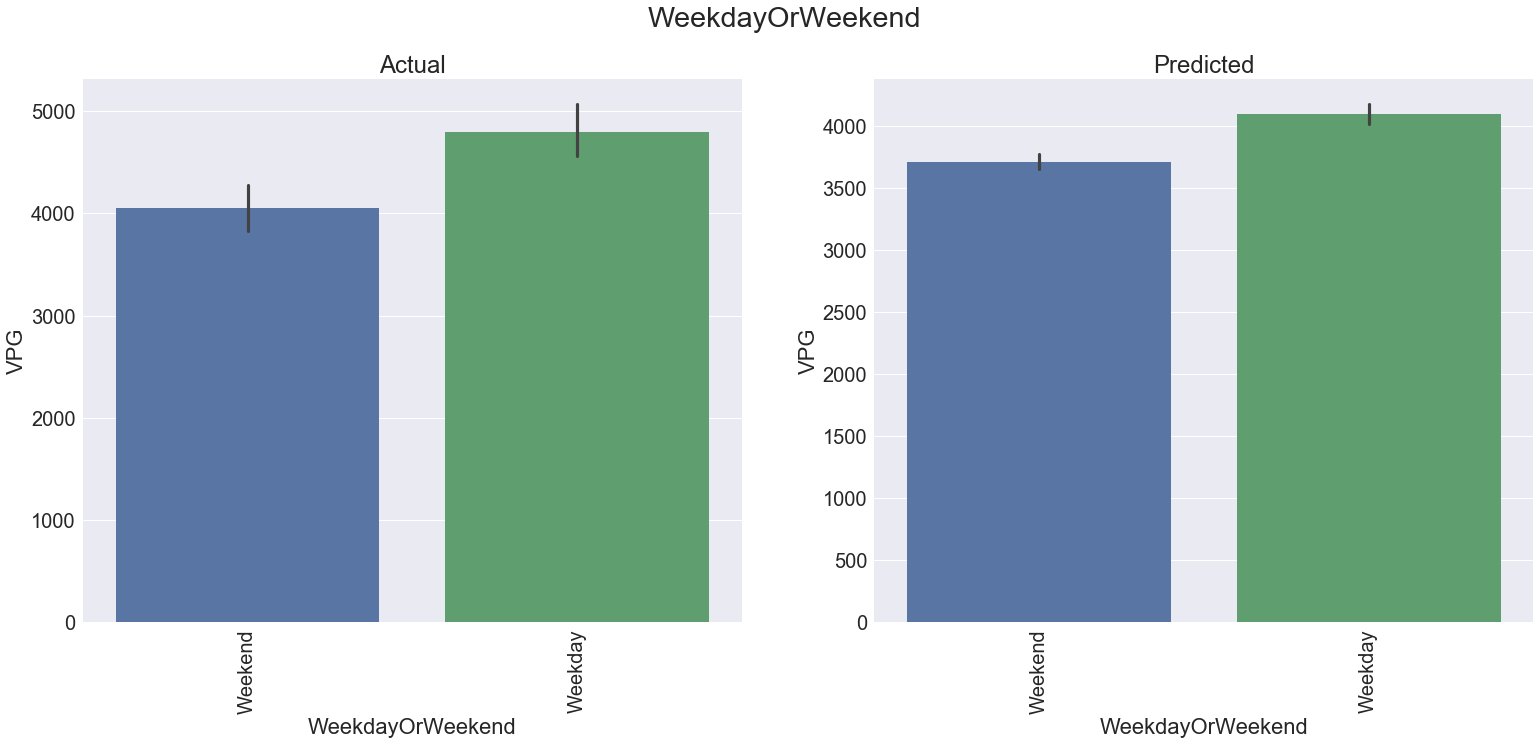

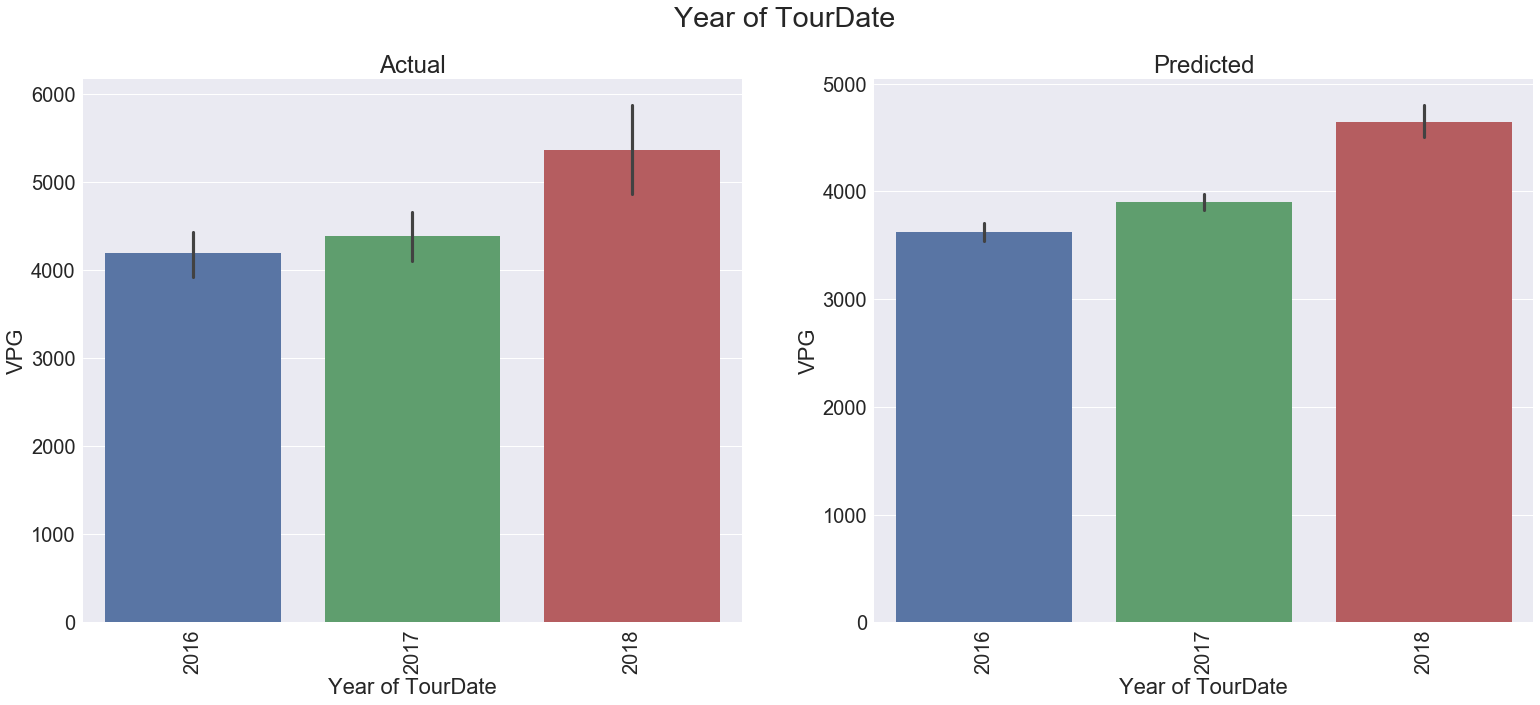

In [16]:
#increase  figure size
mpl.rcParams['figure.figsize'] = (26,10)
sns.set(font_scale = 2)
for i in clfDF.columns[:10]:
    plt.subplot(1,2,1)
    sns.barplot(x= i,y = 'NetVolumePlusNonGoodVolume', data = df)
    plt.xticks(rotation=90)
    plt.ylabel('VPG')
    plt.title('Actual')
    plt.subplot(1,2,2)
    sns.barplot(x= i,y = 'ProspectValue', data = clfDF)
    plt.xticks(rotation=90)
    plt.ylabel('VPG')
    plt.title('Predicted')
    plt.suptitle(i)
    plt.show()

